<a href="https://colab.research.google.com/github/adrianacupp/NLP_with_Transformers/blob/main/Text_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset

how emotions are represented in English Twitter messages.
this dataset contains six basic emotions: anger, disgust, fear, joy, sadness, and surprise. Given a tweet, the task will be to train a model that can classify it into one of these emotions.

In [1]:
!pip install datasets

In [2]:
#list dataset from huggingface datasets
from datasets import list_datasets

In [3]:
all_datasets = list_datasets()

<ipython-input-3-f6f3a82aff2d>:1: FutureWarning: list_datasets is deprecated and will be removed in the next major version of datasets. Use 'huggingface_hub.list_datasets' instead.
  all_datasets = list_datasets()


In [4]:
print(f"There are {len(all_datasets)} datasets currently available on the Hub")
print(f"The first 10 are: {all_datasets[:10]}")

There are 70163 datasets currently available on the Hub
The first 10 are: ['acronym_identification', 'ade_corpus_v2', 'adversarial_qa', 'aeslc', 'afrikaans_ner_corpus', 'ag_news', 'ai2_arc', 'air_dialogue', 'ajgt_twitter_ar', 'allegro_reviews']


In [5]:
emotion_datasets = [dataset for dataset in all_datasets if "emotion" in dataset.lower()]

print(len(emotion_datasets))

250


In [6]:
#load the twitter emotion dataset
from datasets import load_dataset

In [7]:
emotions = load_dataset("emotion")

In [8]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [9]:
train_ds = emotions['train']
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [10]:
len(train_ds)

16000

In [11]:
train_ds[0]

{'text': 'i didnt feel humiliated', 'label': 0}

In [12]:
train_ds.column_names

['text', 'label']

In [13]:
#access features of the dataset
print(train_ds.features)

{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}


In [14]:
#access several rows within a slice
print(train_ds[:5])

{'text': ['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy'], 'label': [0, 0, 3, 2, 3]}


# DataFrame

In [15]:
import pandas as pd

In [16]:
emotions.set_format(type='pandas')

In [17]:
emotions['train']

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [18]:
df = emotions['train'][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [19]:
#create a col with the corresponding label name
def label_int2str(row):
  return emotions['train'].features['label'].int2str(row)

In [20]:
df['label_name'] = df['label'].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


# EDA

class distribution

In [21]:
import matplotlib.pyplot as plt

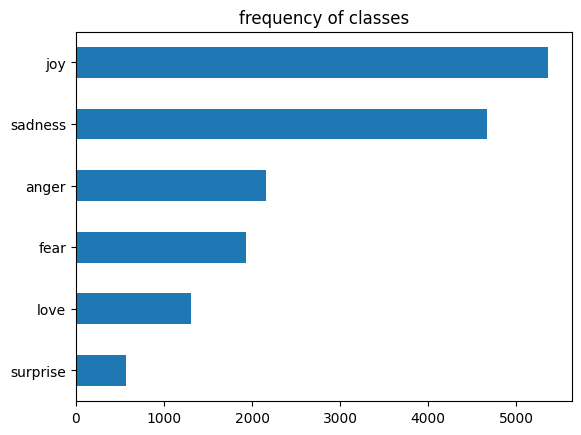

In [22]:
df.label_name.value_counts(ascending=True).plot.barh()
plt.title('frequency of classes')
plt.show()

how long are our tweets?

In [23]:
#create a col words per tweet
df['words_per_tweet'] = df['text'].str.split().apply(len)

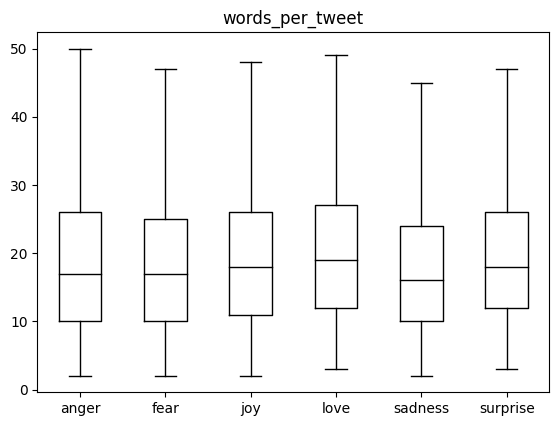

In [24]:
df.boxplot('words_per_tweet', by='label_name', grid=False,
           showfliers=False, color='black')
plt.suptitle("")
plt.xlabel("")
plt.show()

# Tokens

In [25]:
emotions.reset_format()

##Character Tokenization

In [26]:
text = 'Tokenizing text is a core task of NLP.'

In [27]:
tokenized_text= list(text)

In [28]:
print(tokenized_text)

['T', 'o', 'k', 'e', 'n', 'i', 'z', 'i', 'n', 'g', ' ', 't', 'e', 'x', 't', ' ', 'i', 's', ' ', 'a', ' ', 'c', 'o', 'r', 'e', ' ', 't', 'a', 's', 'k', ' ', 'o', 'f', ' ', 'N', 'L', 'P', '.']


In [29]:
enumerate(sorted(set(tokenized_text)))

In [30]:
#model expects each character to be converted into integer
token2id = {ch: idx for idx, ch in enumerate(sorted(set(tokenized_text)))}

In [31]:
print(token2id)

{' ': 0, '.': 1, 'L': 2, 'N': 3, 'P': 4, 'T': 5, 'a': 6, 'c': 7, 'e': 8, 'f': 9, 'g': 10, 'i': 11, 'k': 12, 'n': 13, 'o': 14, 'r': 15, 's': 16, 't': 17, 'x': 18, 'z': 19}


In [32]:
#transform tokenized text to a list of integers
input_ids = [token2id[token] for token in tokenized_text]
print(input_ids)

[5, 14, 12, 8, 13, 11, 19, 11, 13, 10, 0, 17, 8, 18, 17, 0, 11, 16, 0, 6, 0, 7, 14, 15, 8, 0, 17, 6, 16, 12, 0, 14, 9, 0, 3, 2, 4, 1]


In [33]:
#transform unique numerical identifier to a 2D tensor of one-hot vectors (use Pytorch)
import torch
import torch.nn.functional as F


In [34]:
#convert input_ids to tensor
input_ids = torch.tensor(input_ids)

In [35]:
one_hot_encodings = F.one_hot(input_ids,num_classes=len(token2id))
one_hot_encodings.shape
#for each of the 38 input tokens we now have one-hot vector with 20 dimensions.
#never forget to set num_classes= !!

torch.Size([38, 20])

In [36]:
#check if a 1 appears the location indicated by input_id[0]
print(f"token: {tokenized_text[0]}")
print(f"tensor index: {input_ids[0]}")
print(f"one_hot_: {one_hot_encodings[0]}")

token: T
tensor index: 5
one_hot_: tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


##Word Tokenization

In [37]:
tokenized_text = text.split()
print(tokenized_text)

['Tokenizing', 'text', 'is', 'a', 'core', 'task', 'of', 'NLP.']


In [38]:
token2idx = {ch: idx for idx, ch in enumerate(sorted(set(tokenized_text)))}
print(token2idx)

{'NLP.': 0, 'Tokenizing': 1, 'a': 2, 'core': 3, 'is': 4, 'of': 5, 'task': 6, 'text': 7}


In [39]:
#punctuation and stem are not recognised, therefore:
import string
import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [40]:
# Tokenize the text
tokenized_text = word_tokenize(text)

# Initialize the WordNet lemmatizer
lemmatizer = WordNetLemmatizer()

# Lemmatize and remove punctuation
lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokenized_text if token not in string.punctuation]

print(lemmatized_tokens)

['Tokenizing', 'text', 'is', 'a', 'core', 'task', 'of', 'NLP']


In [41]:
#assign to each token a unique numerical identifier
token2idx = {ch: idx for idx, ch in enumerate(sorted(set(lemmatized_tokens)))}
print(token2idx)

{'NLP': 0, 'Tokenizing': 1, 'a': 2, 'core': 3, 'is': 4, 'of': 5, 'task': 6, 'text': 7}


In [42]:
#transform tokenized text to a list of integers
input_ids = [token2idx[token] for token in lemmatized_tokens]
print(input_ids)

[1, 7, 4, 2, 3, 6, 5, 0]


In [43]:
#convert list of integers input_ids to tensor
input_ids = torch.tensor(input_ids)

In [44]:
one_hot_encodings = F.one_hot(input_ids,num_classes=len(token2idx))
one_hot_encodings.shape
#for each of the 8 input tokens we now have one-hot vector with 8 dimensions.
#never forget to set num_classes= !!

torch.Size([8, 8])

In [45]:
#check if Tokenizing appears the location indicated by input_ids[0]
print(f"token: {lemmatized_tokens[0]}")
print(f"tensor index: {input_ids[0]}")
print(f"one_hot_: {one_hot_encodings[0]}")

token: Tokenizing
tensor index: 1
one_hot_: tensor([0, 1, 0, 0, 0, 0, 0, 0])


## Subword Tokenization

In [46]:
#combine character and word tokeniz.
#1)split rare words into smaller units
#2)keep frequent words as unique entities
#WordPiece used by BERT and DistillBERT
# !!! it is really important to make sure that you use the same tokenizer that the model was trained with!

In [47]:
from transformers import AutoTokenizer

In [48]:
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [49]:
tokenizer.vocab_size

30522

In [50]:
tokenizer.model_max_length

512

In [51]:
tokenizer.model_input_names

['input_ids', 'attention_mask']

In [52]:
#or you load the specific class manually
from transformers import DistilBertTokenizer

In [53]:
distilbert_tokenizer = DistilBertTokenizer.from_pretrained(model_ckpt)

In [54]:
encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [55]:
#convert ids to tokens
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl', '##p', '.', '[SEP]']


In [56]:
# CLS and SEP start and end
# lower-cased
# ## preceding string is not whitespace

In [57]:
print(tokenizer.convert_tokens_to_string(tokens))

[CLS] tokenizing text is a core task of nlp. [SEP]


## Tokenizing the whole Dataset

In [58]:
def tokenize(batch):
  return tokenizer(batch['text'], padding=True, truncation=True)
#padding=True adds tokens to the shorter sequences, extending them to match the lenght
#of the longest sequences (text in this case) in the batch

In [59]:
print(tokenize(emotions['train'][:2]))
##attention_mask allows the model to ignore the padded parts of the inputs

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [60]:
#apply the function to all splits in the corpus
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)
#batch_size=None token function is applied to whole dataset as a single batch --> input tensor and attention masks have the same shape globally

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [61]:
print(emotions_encoded['train'].column_names)

['text', 'label', 'input_ids', 'attention_mask']


# Training Text Classifier

## Feature Extraction

In [62]:
# train the classifier model only on hidden states (embedding: i.e., dense numerical representations)
# as features without modifying the pretrained model.
# GPU not necessary

In [63]:
#load the weights of a pretrained model
from transformers import AutoModel

In [64]:
model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [65]:
model = AutoModel.from_pretrained(model_ckpt).to(device)
#with Pytorch: this code ensures that model will run on the GPU if we have one.
#the AutoModel class converts the token encodings to embeddings and
#then feeds them through the encoder stack to return the hidden states

warm up: let's retrieve the last hidden states for a single string

In [66]:
text='this is a test'
inputs = tokenizer(text, return_tensors='pt') # encode the string and convert tokens to pytorch tensor
print(f"input tensor shape: {inputs['input_ids'].size()}")
#output: batch_size, n_tokens

input tensor shape: torch.Size([1, 6])


In [67]:
# place the batch_size, n_tokens on the same device as the model and pass the inputs as follows:
inputs = {k:v.to(device) for k,v in inputs.items()}

In [68]:
with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]],
       device='cuda:0'), hidden_states=None, attentions=None)


In [69]:
outputs.last_hidden_state.size()
#768-dimensional vectors is returned for each of the 6 input tokens

torch.Size([1, 6, 768])

In [70]:
outputs.last_hidden_state[:,0].size()

torch.Size([1, 768])

whole dataset

In [71]:
# create hidden states associated with each tweet

def extract_hidden_states(batch):
    # Place model inputs on the GPU
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}
    # Extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # Return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [72]:
emotions_encoded.set_format("torch",
                            columns=["input_ids", "attention_mask", "label"])

In [73]:
#hide_output
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [74]:
emotions_hidden["train"].column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

In [75]:
save_path = "My Drive/Colab_Notebooks/NLP_with_Transformers/emotions_hidden"
emotions_hidden.save_to_disk(save_path)

Saving the dataset (0/1 shards):   0%|          | 0/16000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/2000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/2000 [00:00<?, ? examples/s]

In [76]:
from datasets import load_from_disk

# Specify the path to the saved dataset
saved_path = "My Drive/Colab_Notebooks/NLP_with_Transformers/emotions_hidden"  # Use the correct path to your saved dataset

# Load the saved dataset
loaded_emotions_hidden = load_from_disk(saved_path)


Text Classifier

In [77]:
#use the hidden states as input features and the labels as targets
import numpy as np

X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])

y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])

X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

Visualizing the training set

In [79]:
!pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.8/90.8 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 39.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.4-py3-none-any.whl size=86770 sha256=60e41cab3b05e36a9786a44cd096404497de8b886848b3ca16bb5b7fac507cb0
  Stored in directory: /root/.cache/pip/wheels/fb/66/29/199acf5784d0f7b8add6d466175ab45506c96e386ed5dd0633
  Created wheel for pynndescent: filename=pynndescent-0.5.10-py3-none-any.whl size=55615 sha256=1461c4f229721d0b06db51986fe60e6ef57054596c048ac87754c12a9b85c6e9
  Stored in directory: /root/.cache/pip/wheels/4a/38/5d/f60a40a66a9512b7e5e83517ebc2d1b42d857be97d135f1096
Successfully built umap-learn pynndescent


In [81]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler


In [82]:
#scale features to 0,1 range
X_scaled = MinMaxScaler().fit_transform(X_train)

In [83]:
#initialize and fit UMAP
mapper = UMAP(n_components=2, metric='cosine').fit(X_scaled)

In [84]:
#create a dataframe of 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_,columns=['X','Y'])
df_emb['label'] = y_train
df_emb.head()
#2 features insted of initial 768

,X,Y,label
0,4.208767,5.906312,0
1,-3.336407,5.157869,0
2,5.115876,2.470673,3
3,-2.558109,3.145841,2
4,-3.586710,3.148206,3


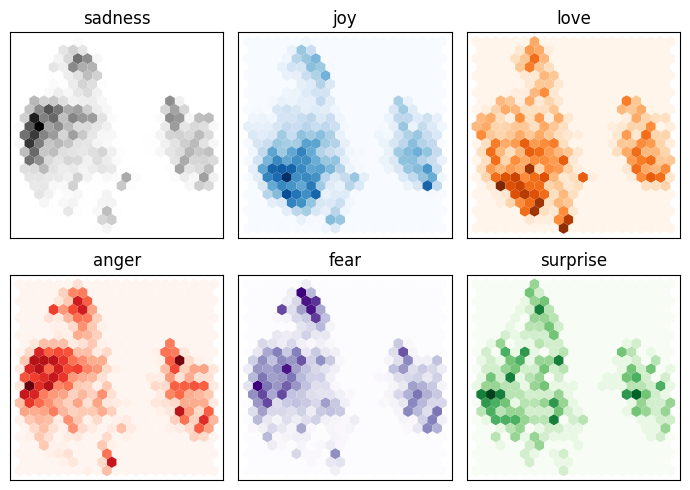

In [85]:
fig, axes = plt.subplots(2, 3, figsize=(7,5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = emotions["train"].features["label"].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap,
                   gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()

Logistic Regression

In [86]:
# use these hiddenstates to train a logistic regression model with scikitlearn
from sklearn.linear_model import LogisticRegression

In [87]:
#increase mx_iter to guarantee convergence
lr_clf = LogisticRegression(max_iter=3000)

In [88]:
lr_clf.fit(X_train, y_train)

LogisticRegression(max_iter=3000)

In [89]:
lr_clf.score(X_valid, y_valid)

0.633

In [90]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.352

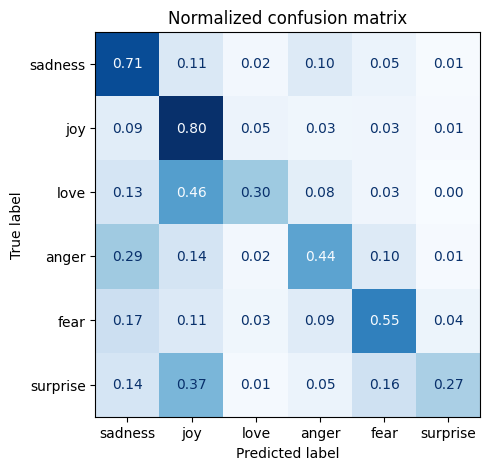

In [91]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(5, 5))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)



## Fine-Tuning Transformers

In [92]:
#!pip install transformers

In [93]:
from transformers import AutoModelForSequenceClassification

In [94]:
import torch
import torch.nn.functional as F

Loading pre-trained model

In [95]:
model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [96]:
num_labels = 6
model = (AutoModelForSequenceClassification.
         from_pretrained(model_ckpt,num_labels=num_labels)
         .to(device))

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.weight', 'pre_classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Performance Metrics

In [97]:
from sklearn.metrics import accuracy_score, f1_score

In [108]:
 #the function extracts the model's predictions from the pred object and calculates the class
#with the highest predicted probability for each data point.
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

Training the Model

In [99]:
!pip install huggingface_hub

In [109]:
from huggingface_hub import notebook_login

In [110]:
notebook_login()
#user access toke, mod:WRITE (not READ)

In [111]:
from transformers import Trainer, TrainingArguments

In [103]:
! pip install -U accelerate
! pip install -U transformers

In [112]:
#setting up the training configurations for fine-tuning a transformer model
batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size #how often training logs are generated
model_name = f"{model_ckpt}-finetuned-emotion" #the output directory where the fine-tuned model and related artifacts will be saved
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=True,
                                  log_level="error")

In [113]:
#instatiate and fine-tune the model
from transformers import Trainer

In [114]:
trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded["train"],
                  eval_dataset=emotions_encoded["validation"],
                  tokenizer=tokenizer)
trainer.train();

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.215000,0.183239,0.928000,0.929099
2,0.138600,0.159278,0.931500,0.932045


In [ ]:
# predictions on the validation set
preds_output = trainer.predict(emotions_encoded["validation"])


In [116]:
preds_output.metrics

{'test_loss': 0.15927840769290924,
 'test_accuracy': 0.9315,
 'test_f1': 0.9320450067236951,
 'test_runtime': 4.3049,
 'test_samples_per_second': 464.591,
 'test_steps_per_second': 7.433}

In [117]:
y_preds = np.argmax(preds_output.predictions, axis=1)

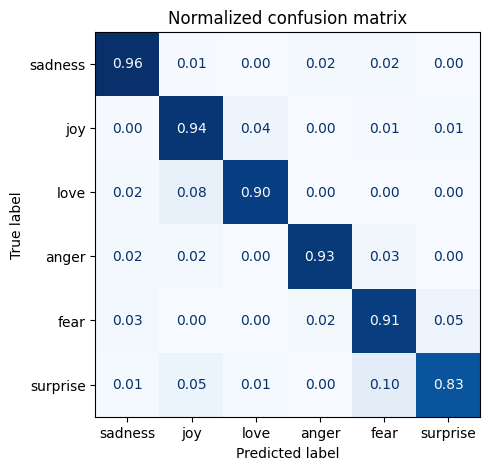

In [118]:
#confusion matrix
plot_confusion_matrix(y_preds, y_valid, labels)

Error Analysis

In [119]:
#sorting the validation samples by the model loss
from torch.nn.functional import cross_entropy

In [120]:
def forward_pass_with_label(batch):
    # Place all input tensors on the same device as the model
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device),
                             reduction="none")

    # Place outputs on CPU for compatibility with other dataset columns
    return {"loss": loss.cpu().numpy(),
            "predicted_label": pred_label.cpu().numpy()}


In [121]:
# Convert our dataset back to PyTorch tensors
emotions_encoded.set_format("torch",
                            columns=["input_ids", "attention_mask", "label"])
# Compute loss values
emotions_encoded["validation"] = emotions_encoded["validation"].map(
    forward_pass_with_label, batched=True, batch_size=16)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [122]:
emotions_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = emotions_encoded["validation"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = (df_test["predicted_label"]
                              .apply(label_int2str))

In [123]:
df_test.sort_values("loss", ascending=False).head(10)
#

,text,label,predicted_label,loss
1950,i as representative of everything thats wrong ...,surprise,sadness,7.225431
1509,i guess this is a memoir so it feels like that...,joy,fear,6.386341
1111,im lazy my characters fall into categories of ...,joy,fear,6.194137
882,i feel badly about reneging on my commitment t...,love,sadness,6.182528
318,i felt ashamed of these feelings and was scare...,fear,sadness,5.813640
1870,i guess i feel betrayed because i admired him ...,joy,sadness,5.810180
1963,i called myself pro life and voted for perry w...,joy,sadness,5.735700
997,i feel as if there is anyone who really unders...,anger,joy,5.391882
1500,i guess we would naturally feel a sense of lon...,anger,sadness,5.384479
1836,i got a very nasty electrical shock when i was...,fear,anger,5.061851


In [124]:
df_test.sort_values("loss", ascending=True).head(10)

,text,label,predicted_label,loss
1873,i feel practically virtuous this month i have ...,joy,joy,0.003260
578,i got to christmas feeling positive about the ...,joy,joy,0.003421
702,i only find out that they are looking and feel...,joy,joy,0.003430
1205,i log on feeling vaguely sociable and after a ...,joy,joy,0.003508
941,i expected but it did feel hopeful and it defi...,joy,joy,0.003530
11,i was dribbling on mums coffee table looking o...,joy,joy,0.003549
669,i am not feeling very joyful today its been a ...,joy,joy,0.003557
1265,im feeling more hopeful today than i did yeste...,joy,joy,0.003572
1421,i feel undeservingly lucky to be surrounded by...,joy,joy,0.003582
557,i really do feel so peaceful right now as i ty...,joy,joy,0.003588


Saving and sharing the model

In [125]:
trainer.push_to_hub(commit_message="Training completed!")

'https://huggingface.co/AdrianaCup/distilbert-base-uncased-finetuned-emotion/tree/main/'

use the fine-tuned model to make predictions on new tweets

In [126]:
from transformers import pipeline

# Change `transformersbook` to your Hub username
#download your model
model_id = "transformersbook/distilbert-base-uncased-finetuned-emotion"
classifier = pipeline("text-classification", model=model_id)


In [127]:
custom_tweet = "I saw a movie today and it was really good."
preds = classifier(custom_tweet, return_all_scores=True)

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:105: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


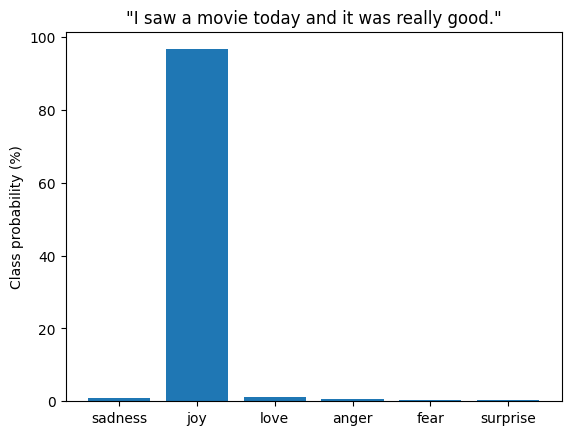

In [128]:
preds_df = pd.DataFrame(preds[0])
plt.bar(labels, 100 * preds_df["score"], color='C0')
plt.title(f'"{custom_tweet}"')
plt.ylabel("Class probability (%)")
plt.show()